# Differential Analysis - Compare model imputation with standard imputation

- load missing values predictions (if specified)
- leave all other values as they were
- compare missing values predicition by model with baseline method
  (default: draw from shifted normal distribution. short RSN)

In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import njab.stats
import pandas as pd
from IPython.display import display

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.imputation
import pimmslearn.io.datasplits
import pimmslearn.nb

logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.WARNING)

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [3]:
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'
f_annotations = 'data/ALD_study/processed/ald_plasma_proteinGroups_id_mappings.csv'


target: str = 'kleiner'
covar: str = 'age,bmi,gender_num,nas_steatosis_ordinal,abstinent_num'

file_format = "csv"
model_key = 'VAE'  # model(s) to evaluate
model = None  # default same as model_key, but could be overwritten (edge case)
value_name = 'intensity'
out_folder = 'diff_analysis'
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [4]:
# Parameters
f_annotations = None
folder_experiment = "runs/alzheimer_study"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"
target = "AD"
covar = "age,Kiel,Magdeburg,Sweden"
model_key = "TRKNN"
out_folder = "diff_analysis"


Add set parameters to configuration

In [5]:
if not model:
    model = model_key
params = pimmslearn.nb.get_params(args, globals=globals(), remove=True)
params

root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: f_annotations


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: covar


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: model


root - INFO     Removed from global namespace: value_name


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: template_pred


{'folder_experiment': 'runs/alzheimer_study',
 'folder_data': '',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'f_annotations': None,
 'target': 'AD',
 'covar': 'age,Kiel,Magdeburg,Sweden',
 'file_format': 'csv',
 'model_key': 'TRKNN',
 'model': 'TRKNN',
 'value_name': 'intensity',
 'out_folder': 'diff_analysis',
 'template_pred': 'pred_real_na_{}.csv'}

In [6]:
args = pimmslearn.nb.Config()
args.fn_clinical_data = Path(params["fn_clinical_data"])
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           ))
args.covar = params["covar"].split(',')
args.update_from_dict(params)
args

root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: fn_clinical_data has value runs/alzheimer_study/data/clinical_data.csv


root - INFO     Already set attribute: covar has value age,Kiel,Magdeburg,Sweden


root - INFO     Already set attribute: out_folder has value diff_analysis


{'covar': ['age', 'Kiel', 'Magdeburg', 'Sweden'],
 'data': PosixPath('runs/alzheimer_study/data'),
 'f_annotations': None,
 'file_format': 'csv',
 'fn_clinical_data': PosixPath('runs/alzheimer_study/data/clinical_data.csv'),
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model': 'TRKNN',
 'model_key': 'TRKNN',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv',
 'value_name': 'intensity'}

Outputs of this notebook will be stored here:

In [7]:
files_out = {}
args.out_folder

PosixPath('runs/alzheimer_study/diff_analysis/AD')

## Data

### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [8]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


In [9]:
observed = pd.concat([data.train_X, data.val_y, data.test_y])
observed

Sample ID   protein groups                                                                
Sample_000  A0A024QZX5;A0A087X1N8;P35237                                                     15.912
            A0A024R0T9;K7ER74;P02655                                                         16.852
            A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8   15.570
            A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                          16.481
            A0A075B6H7                                                                       17.301
                                                                                              ...  
Sample_209  Q96ID5                                                                           16.074
            Q9H492;Q9H492-2                                                                  13.173
            Q9HC57                                                                           14.207
         

### Clinical data
Describe numerical data specified for use:

In [10]:
df_clinic = pd.read_csv(args.fn_clinical_data, index_col=0)
df_clinic = df_clinic.loc[observed.index.levels[0]]
cols_clinic = pimmslearn.pandas.get_columns_accessor(df_clinic)
df_clinic[[args.target, *args.covar]].describe()

,AD,age,Kiel,Magdeburg,Sweden
count,210.000,197.000,210.000,210.000,210.000
mean,0.419,67.726,0.076,0.181,0.286
std,0.495,12.123,0.266,0.386,0.453
min,0.000,20.000,0.000,0.000,0.000
25%,0.000,63.000,0.000,0.000,0.000
50%,0.000,70.000,0.000,0.000,0.000
75%,1.000,74.000,0.000,0.000,1.000
max,1.000,88.000,1.000,1.000,1.000


In [11]:
# ## Additional annotations
# - additional annotations of features (e.g. gene names for protein groups)

feat_name = observed.index.names[-1]
if args.f_annotations:
    gene_to_PG = pd.read_csv(args.f_annotations)
    gene_to_PG = gene_to_PG.drop_duplicates().set_index(feat_name)
    fname = args.out_folder / Path(args.f_annotations).name
    gene_to_PG.to_csv(fname)
    files_out[fname.name] = fname.as_posix()
else:
    gene_to_PG = None
gene_to_PG

Entries with missing values
- see how many rows have one missing values (for target and covariates)
- only complete data is used for Differential Analysis
- covariates are not imputed

In [12]:
df_clinic[[args.target, *args.covar]].isna().any(axis=1).sum()

13

Data description of data used:

In [13]:
mask_sample_with_complete_clinical_data = df_clinic[[args.target, *args.covar]].notna().all(axis=1)
fname = args.out_folder / 'mask_sample_with_complete_clinical_data.csv'
files_out[fname.name] = fname.as_posix()
mask_sample_with_complete_clinical_data.to_csv(fname)

idx_complete_data = (mask_sample_with_complete_clinical_data
                     .loc[mask_sample_with_complete_clinical_data]
                     .index)
df_clinic.loc[idx_complete_data, [args.target, *args.covar]].describe()

,AD,age,Kiel,Magdeburg,Sweden
count,197.000,197.000,197.000,197.000,197.000
mean,0.447,67.726,0.081,0.193,0.305
std,0.498,12.123,0.274,0.396,0.461
min,0.000,20.000,0.000,0.000,0.000
25%,0.000,63.000,0.000,0.000,0.000
50%,0.000,70.000,0.000,0.000,0.000
75%,1.000,74.000,0.000,0.000,1.000
max,1.000,88.000,1.000,1.000,1.000


In [14]:
df_clinic.loc[idx_complete_data, args.target].value_counts()

AD
0   109
1    88
Name: count, dtype: int64

Check which patients with kleiner score have misssing covariates:

In [15]:
df_clinic.loc[(~mask_sample_with_complete_clinical_data
               & df_clinic[args.target].notna()),
              [args.target, *args.covar]]

,AD,age,Kiel,Magdeburg,Sweden
Sample ID,,,,,
Sample_021,0,NaN,0,0,0
Sample_065,0,NaN,0,0,0
Sample_066,0,NaN,0,0,0
Sample_067,0,NaN,0,0,0
Sample_082,0,NaN,0,0,0
Sample_108,0,NaN,0,0,0
Sample_120,0,NaN,0,0,0
Sample_135,0,NaN,0,0,0
Sample_138,0,NaN,0,0,0


Save feature frequency of observed data based on complete clinical data

root - INFO     runs/alzheimer_study/freq_features_observed.csv


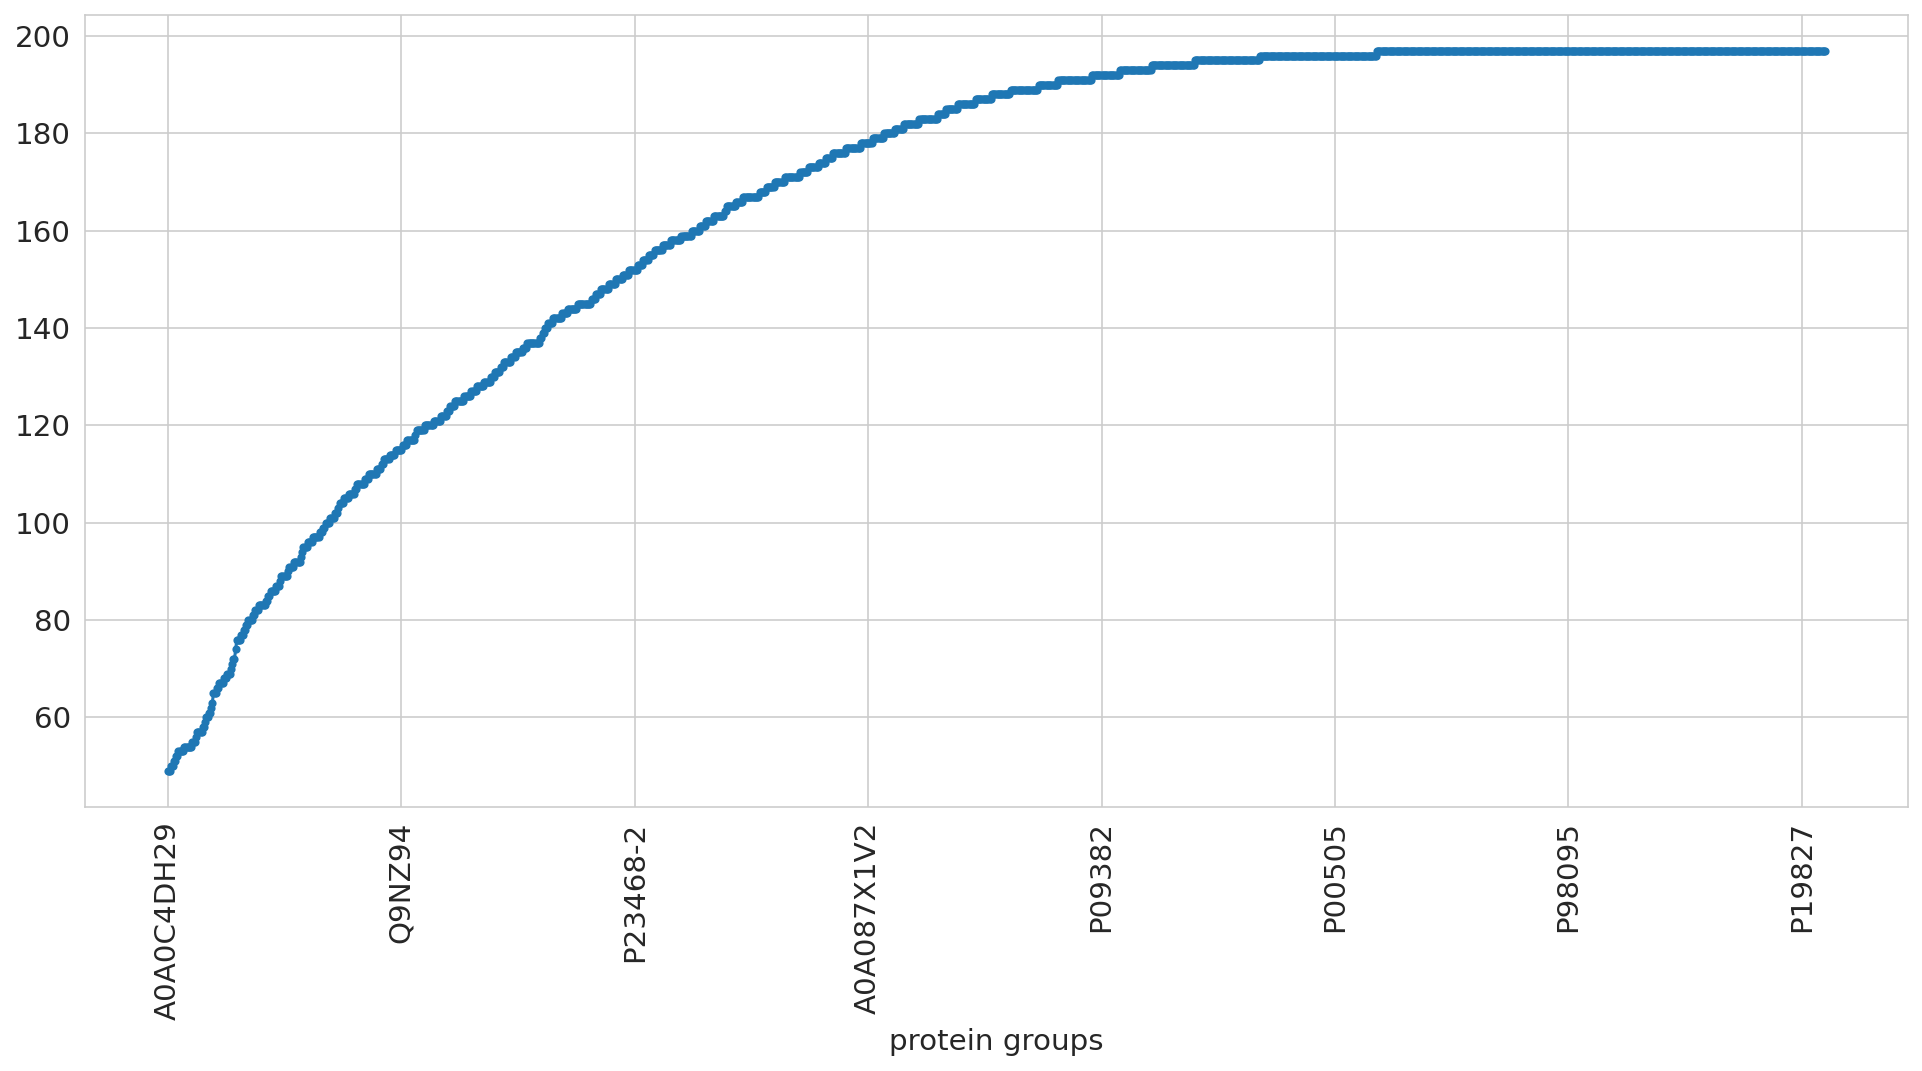

In [16]:
feat_freq_observed = observed.unstack().loc[idx_complete_data].notna().sum()
feat_freq_observed.name = 'frequency'

fname = args.folder_experiment / 'freq_features_observed.csv'
files_out['feat_freq_observed'] = fname.as_posix()
logger.info(fname)
feat_freq_observed.to_csv(fname)
ax = feat_freq_observed.sort_values().plot(marker='.', rot=90)
_ = ax.set_xticklabels([l_.get_text().split(';')[0] for l_ in ax.get_xticklabels()])

## ALD study approach using all measurements
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [17]:
DATA_COMPLETENESS = 0.6
# MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4  # Coef. of variation on 13 QC samples

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(observed.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [18]:
if args.fn_qc_samples:
    # Move this to data-preprocessing
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    pimmslearn.savefig(fig, name='cv_qc_samples', folder=args.out_figures)
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    # only to ald_study data
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples[ald_study.columns])]

ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/tresholds_normal_imputation


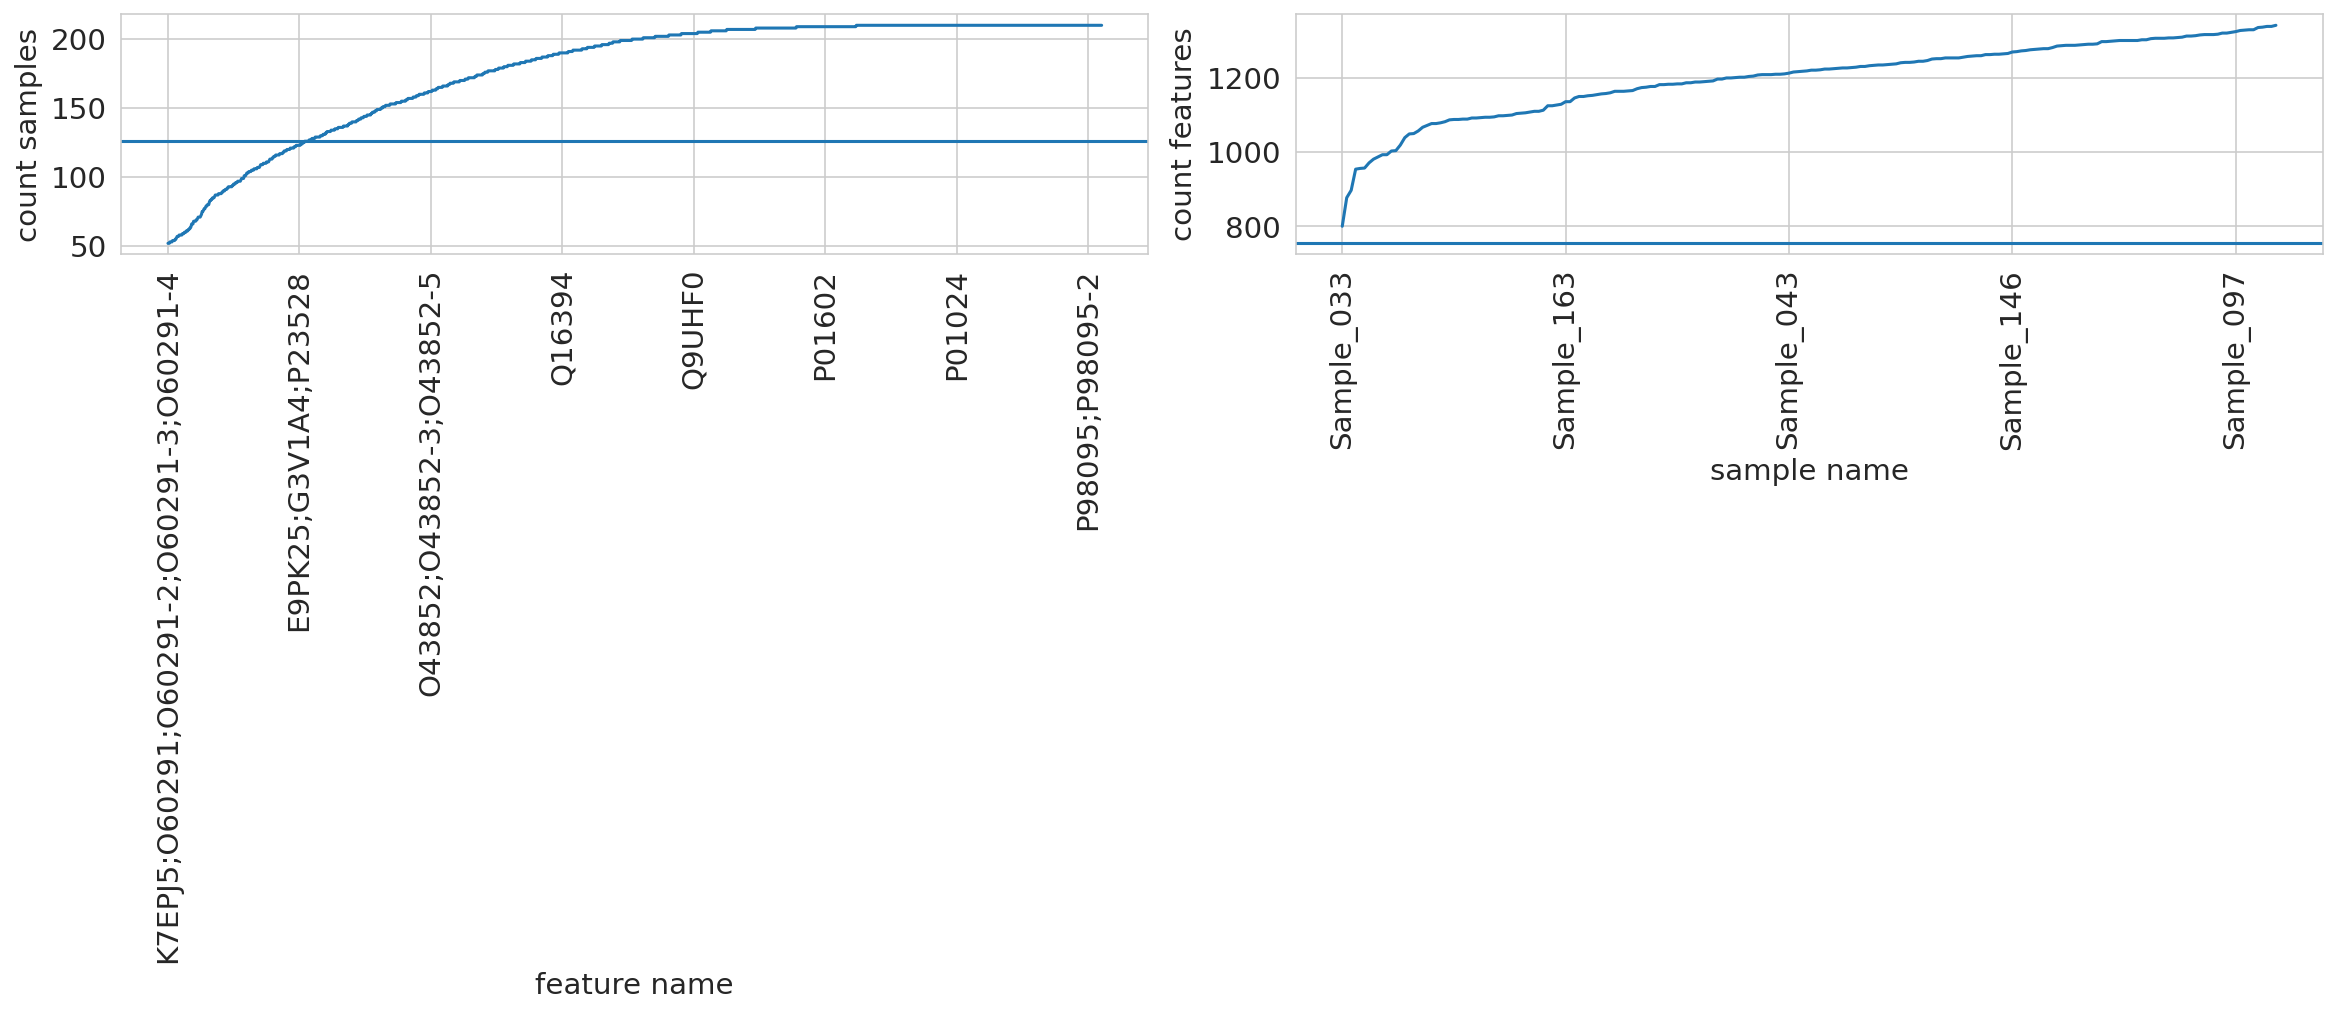

In [19]:
fig, axes = pimmslearn.plotting.plot_cutoffs(observed.unstack(),
                                       feat_completness_over_samples=cutoffs.feat_completness_over_samples,
                                       min_feat_in_sample=cutoffs.min_feat_in_sample)
pimmslearn.savefig(fig, name='tresholds_normal_imputation', folder=args.out_figures)

## Load model predictions for (real) missing data
Load from:

In [20]:
# available_files = list(args.out_preds.iterdir())
template_pred = str(args.out_preds / args.template_pred)
fname = args.out_preds / args.template_pred.format(args.model)
fname

PosixPath('runs/alzheimer_study/preds/pred_real_na_TRKNN.csv')

Baseline comparison:
- in case of RSN -> use filtering as done in original [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study) (Niu et al. 2022)
- otherwise -> use all data

Use columns which are provided by model

In [21]:
pred_real_na = None
if args.model_key and str(args.model_key) != 'None':
    pred_real_na = (pimmslearn
                    .analyzers
                    .compare_predictions
                    .load_single_csv_pred_file(fname)
                    )
else:
    logger.info('No model key provided -> no imputation of data.')

if args.model_key == 'RSN':
    logger.info('Filtering of data as done in original paper for RSN.')
    # Select only idx from RSN which are selected by ald study cutoffs
    idx_to_sel = ald_study.columns.intersection(pred_real_na.index.levels[-1])
    pred_real_na = pred_real_na.loc[pd.IndexSlice[:, idx_to_sel]]
pred_real_na

Sample ID   protein groups          
Sample_000  A0A075B6J9                 15.602
            A0A075B6Q5                 15.958
            A0A075B6R2                 16.350
            A0A075B6S5                 16.654
            A0A087WSY4                 16.040
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   16.028
            Q9UI40;Q9UI40-2            16.591
            Q9UIW2                     16.105
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.192
            Q9UP79                     15.874
Name: intensity, Length: 46401, dtype: float64

Plot unchanged observed intensities to imputed intensity distribution (if available):

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/dist_plots/real_na_obs_vs_TRKNN.pdf


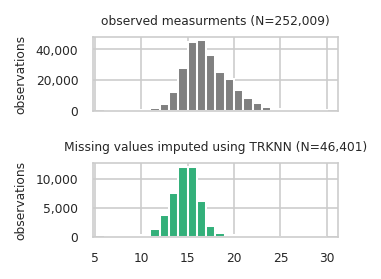

In [22]:
def plot_distributions(observed: pd.Series,
                       imputation: pd.Series = None,
                       model_key: str = 'MODEL',
                       figsize=(4, 3),
                       sharex=True):
    """Plots distributions of intensities provided as dictionary of labels to pd.Series."""
    series_ = [observed, imputation] if imputation is not None else [observed]
    min_bin, max_bin = pimmslearn.plotting.data.get_min_max_iterable([observed])

    if imputation is not None:
        fig, axes = plt.subplots(len(series_), figsize=figsize, sharex=sharex)
        ax = axes[0]
    else:
        fig, ax = plt.subplots(1, figsize=figsize, sharex=sharex)

    bins = range(min_bin, max_bin + 1, 1)

    label = 'observed measurments'
    ax = observed.hist(ax=ax, bins=bins, color='grey')
    ax.set_title(f'{label} (N={len(observed):,d})')
    ax.set_ylabel('observations')
    ax.locator_params(axis='y', integer=True)
    ax.yaxis.set_major_formatter("{x:,.0f}")

    if imputation is not None:
        ax = axes[1]
        label = f'Missing values imputed using {model_key.upper()}'
        color = pimmslearn.plotting.defaults.color_model_mapping.get(model_key, None)
        if color is None:
            color = f'C{1}'
        ax = imputation.hist(ax=ax, bins=bins, color=color)
        ax.set_title(f'{label} (N={len(imputation):,d})')
        ax.set_ylabel('observations')
        ax.locator_params(axis='y', integer=True)
        ax.yaxis.set_major_formatter("{x:,.0f}")
    return fig, bins


pimmslearn.plotting.make_large_descriptors(6)
fig, bins = plot_distributions(observed,
                               imputation=pred_real_na,
                               model_key=args.model_key, figsize=(2.5, 2))
fname = args.out_folder / 'dist_plots' / f'real_na_obs_vs_{args.model_key}.pdf'
files_out[fname.name] = fname.as_posix()
pimmslearn.savefig(fig, name=fname)

Dump frequency of histograms to file for reporting (if imputed values are used)

In [23]:
if pred_real_na is not None:
    counts_per_bin = pd.concat([
        pimmslearn.pandas.get_counts_per_bin(observed.to_frame('observed'), bins=bins),
        pimmslearn.pandas.get_counts_per_bin(pred_real_na.to_frame(args.model_key), bins=bins)
    ], axis=1)
    counts_per_bin.to_excel(fname.with_suffix('.xlsx'))
    logger.info("Counts per bin saved to %s", fname.with_suffix('.xlsx'))
    display(counts_per_bin)

/home/runner/work/pimms/pimms/project/.snakemake/conda/6192e93206804e092b1c71b91535a817_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:319: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _series = (pd.cut(df[col], bins=bins).to_frame().groupby(col).size())
/home/runner/work/pimms/pimms/project/.snakemake/conda/6192e93206804e092b1c71b91535a817_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:319: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _series = (pd.cut(df[col], bins=bins).to_frame().groupby(col).size())


root - INFO     Counts per bin saved to runs/alzheimer_study/diff_analysis/AD/dist_plots/real_na_obs_vs_TRKNN.xlsx


,observed,TRKNN
bin,,
"(6, 7]",1,1
"(7, 8]",4,1
"(8, 9]",39,6
"(9, 10]",136,38
"(10, 11]",529,268
"(11, 12]","1,731","1,339"
"(12, 13]","4,644","3,740"
"(13, 14]","12,161","7,606"
"(14, 15]","27,515","12,089"


## Mean shift by model
Compare how imputed values are shifted in comparsion to overall distribution.

First by using all intensities without any grouping:

In [24]:
if pred_real_na is not None:
    shifts = (pimmslearn.imputation.compute_moments_shift(observed, pred_real_na,
                                                    names=('observed', args.model_key)))
    display(pd.DataFrame(shifts).T)

,mean,std,mean shift (in std),std shrinkage
observed,17.119,2.567,NaN,NaN
TRKNN,14.849,1.619,0.885,0.631


Then by averaging over the calculation by sample:

In [25]:
if pred_real_na is not None:
    index_level = 0  # per sample
    mean_by_sample = pd.DataFrame(
        {'observed': pimmslearn.imputation.stats_by_level(observed, index_level=index_level),
         args.model_key: pimmslearn.imputation.stats_by_level(pred_real_na, index_level=index_level)
         })
    mean_by_sample.loc['mean_shift'] = (mean_by_sample.loc['mean', 'observed'] -
                                        mean_by_sample.loc['mean']).abs() / mean_by_sample.loc['std', 'observed']
    mean_by_sample.loc['std shrinkage'] = mean_by_sample.loc['std'] / \
        mean_by_sample.loc['std', 'observed']
    display(mean_by_sample)

,observed,TRKNN
count,"1,200.043",220.957
mean,17.133,14.831
std,2.564,1.576
mean_shift,0.000,0.898
std shrinkage,1.000,0.615


## Differential analysis
Combine observed and imputed data (if available) for differential analysis:

In [26]:
df = pd.concat([observed, pred_real_na]).unstack()
df.loc[idx_complete_data]

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.770,15.050,16.842,19.863,15.931,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.954,19.067,...,15.528,15.576,13.938,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.006,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,16.035,17.705,17.039,15.261,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.820,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.543,15.345,17.084,18.708,14.249,19.433,12.319,11.307
Sample_207,15.739,16.877,15.469,16.898,15.779,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [27]:
# * if some features were not imputed -> drop them
# ? could be changed: let a model decide if a feature should be imputed, otherwise don't.
if pred_real_na is not None:
    if df.isna().sum().sum():
        logger.warning("DataFrame has missing entries after imputation.")
        logger.info("Drop columns with missing values.")
    df = df.dropna(axis=1)

Results for target and clinical variables:

In [28]:
scores = njab.stats.ancova.AncovaAll(df_proteomics=df,
                                     df_clinic=df_clinic,
                                     target=args.target,
                                     covar=args.covar,
                                     value_name=args.value_name
                                     ).ancova()
# features are in first index position
feat_idx = scores.index.get_level_values(0)
if gene_to_PG is not None:
    scores = (scores
              .join(gene_to_PG)
              .set_index(gene_to_PG.columns.to_list(), append=True)
              )
scores

SS  DF      F  p-unc   np2  \
protein groups               Source                                     
A0A024QZX5;A0A087X1N8;P35237 AD         0.994   1  7.134  0.008 0.036   
                             age        0.004   1  0.029  0.864 0.000   
                             Kiel       0.269   1  1.933  0.166 0.010   
                             Magdeburg  0.519   1  3.727  0.055 0.019   
                             Sweden     1.796   1 12.893  0.000 0.063   
...                                       ...  ..    ...    ...   ...   
S4R3U6                       AD         2.295   1  4.480  0.036 0.023   
                             age        0.398   1  0.777  0.379 0.004   
                             Kiel       2.981   1  5.819  0.017 0.030   
                             Magdeburg  3.440   1  6.716  0.010 0.034   
                             Sweden    27.114   1 52.939  0.000 0.217   

                                        -Log10 pvalue  qvalue  rejected  
protein groups               Source                                      
A0A024QZX5;A0A087X1N8;P35237 AD                 2.085   0.023      True  
                             age                0.063   0.913     False  
                             Kiel               0.780   0.277     False  
                             Magdeburg          1.259   0.114     False  
                             Sweden             3.378   0.002      True  
...                                               ...     ...       ...  
S4R3U6                       AD                 1.449   0.080     False  
                             age                0.421   0.516     False  
                             Kiel               1.775   0.043      True  
                             Magdeburg          1.987   0.028      True  
                             Sweden            11.062   0.000      True  

[7105 rows x 8 columns]

Only for target:

In [29]:
scores.columns = pd.MultiIndex.from_product([[str(args.model_key)], scores.columns],
                                            names=('model', 'var'))
scores.loc[pd.IndexSlice[:, args.target], :]

model                                                     TRKNN           \
var                                                          SS DF     F   
protein groups                                     Source                  
A0A024QZX5;A0A087X1N8;P35237                       AD     0.994  1 7.134   
A0A024R0T9;K7ER74;P02655                           AD     2.916  1 4.736   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;... AD     0.155  1 1.255   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503            AD     0.173  1 1.245   
A0A075B6H7                                         AD     4.134  1 5.536   
...                                                         ... ..   ...   
Q9Y6R7                                             AD     0.675  1 1.850   
Q9Y6X5                                             AD     0.867  1 2.530   
Q9Y6Y8;Q9Y6Y8-2                                    AD     0.973  1 3.028   
Q9Y6Y9                                             AD     0.565  1 0.938   
S4R3U6                                             AD     2.295  1 4.480   

model                                                                  \
var                                                       p-unc   np2   
protein groups                                     Source               
A0A024QZX5;A0A087X1N8;P35237                       AD     0.008 0.036   
A0A024R0T9;K7ER74;P02655                           AD     0.031 0.024   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;... AD     0.264 0.007   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503            AD     0.266 0.006   
A0A075B6H7                                         AD     0.020 0.028   
...                                                         ...   ...   
Q9Y6R7                                             AD     0.175 0.010   
Q9Y6X5                                             AD     0.113 0.013   
Q9Y6Y8;Q9Y6Y8-2                                    AD     0.083 0.016   
Q9Y6Y9                                             AD     0.334 0.005   
S4R3U6                                             AD     0.036 0.023   

model                                                                    \
var                                                       -Log10 pvalue   
protein groups                                     Source                 
A0A024QZX5;A0A087X1N8;P35237                       AD             2.085   
A0A024R0T9;K7ER74;P02655                           AD             1.512   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;... AD             0.578   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503            AD             0.575   
A0A075B6H7                                         AD             1.707   
...                                                                 ...   
Q9Y6R7                                             AD             0.756   
Q9Y6X5                                             AD             0.946   
Q9Y6Y8;Q9Y6Y8-2                                    AD             1.079   
Q9Y6Y9                                             AD             0.476   
S4R3U6                                             AD             1.449   

model                                                                      
var                                                       qvalue rejected  
protein groups                                     Source                  
A0A024QZX5;A0A087X1N8;P35237                       AD      0.023     True  
A0A024R0T9;K7ER74;P02655                           AD      0.071    False  
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;... AD      0.394    False  
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503            AD      0.396    False  
A0A075B6H7                                         AD      0.048     True  
...                                                          ...      ...  
Q9Y6R7                                             AD      0.289    False  
Q9Y6X5                                             AD      0.205    False  
Q9Y6Y8;Q9Y6Y8-2          

Save all results to file:

In [30]:
fname = args.out_folder / 'scores' / f'diff_analysis_scores_{str(args.model_key)}.pkl'
files_out[fname.name] = fname.as_posix()
fname.parent.mkdir(exist_ok=True, parents=True)
scores.to_pickle(fname)
fname

PosixPath('runs/alzheimer_study/diff_analysis/AD/scores/diff_analysis_scores_TRKNN.pkl')

Saved files:

In [31]:
files_out

{'mask_sample_with_complete_clinical_data.csv': 'runs/alzheimer_study/diff_analysis/AD/mask_sample_with_complete_clinical_data.csv',
 'feat_freq_observed': 'runs/alzheimer_study/freq_features_observed.csv',
 'real_na_obs_vs_TRKNN.pdf': 'runs/alzheimer_study/diff_analysis/AD/dist_plots/real_na_obs_vs_TRKNN.pdf',
 'diff_analysis_scores_TRKNN.pkl': 'runs/alzheimer_study/diff_analysis/AD/scores/diff_analysis_scores_TRKNN.pkl'}